In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

from src.semi_sub_utils import  log_pointwise_predictive_likelihood
from src.semi_subspace import *
from src.base_models import SimpleCnn, NllLoss
from src.pyro_models import pyroSemiSubspace
from src.plot import plot_predictive_regression, plot_curve_solutions_regression, plot_subspace, plot_subspace_solution_regression_pyro

from pyro.infer.autoguide import init_to_sample
from pyro.poutine.indep_messenger import IndepMessenger
from copy import deepcopy
import arviz as az


import torch
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
# from pydicom import dcmread
import pytorch_lightning as pl
from torchmetrics import MetricCollection, AUROC, CalibrationError, SumMetric
import wandb
from utils_datamodel.pl_utils import MelanomDataModuleFromSplit
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, Callback
from src.plot import plot_subspace
from src.semiSub_model import cudaIter
from src.curve_models import CurveModel, CurveLogger
from src.plot import exclude_project_code_dirs
from tqdm import tqdm
from src.semi_sub_utils import get_curve_space_torch
from src.semiSub_model import getModel
import pyro
from src.ess import SemiSubEllipticalSliceSampling
from utils_datamodel.utils import FastFillTensorDataLoader
import torchmetrics

# %load_ext tensorboard
sns.set_style("darkgrid")
if torch.cuda.is_available() and 1:
    print("Use cuda. Device: ", torch.cuda.get_device_name(torch.cuda.current_device()))
    device = torch.device('cuda', torch.cuda.current_device())
else:
    device = torch.device('cpu')
print("Device: ", device)
%load_ext autoreload
%autoreload 2
%env WANDB_BASE_URL http://141.37.176.203:8080
%env WANDB_NOTEBOOK_NAME ./train_semi_subspace_melanoma.ipynb

fig_width_pt = 234.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
figsize = [fig_width,fig_height]

fig_width_pt = 487.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
figsize_l = [fig_width,fig_height]
print("Figure size=", figsize)
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amsfonts}',
    "font.family": "Nimbus Sans",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize":figsize
}
plt.rcParams.update(tex_fonts)

Use cuda. Device:  NVIDIA GeForce RTX 3080 Ti
Device:  cuda:0
Use cuda. Device:  NVIDIA GeForce RTX 3080 Ti
Device:  cuda:0
env: WANDB_BASE_URL=http://141.37.176.203:8080
env: WANDB_NOTEBOOK_NAME=./train_semi_subspace_melanoma.ipynb
Figure size= [3.2489276324892766, 2.0079477038671003]


/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/daniel/miniconda3/envs/nppyro5/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


## Analyse posterior

array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'varphi'}>,
        <Axes: title={'center': 'varphi'}>]], dtype=object)

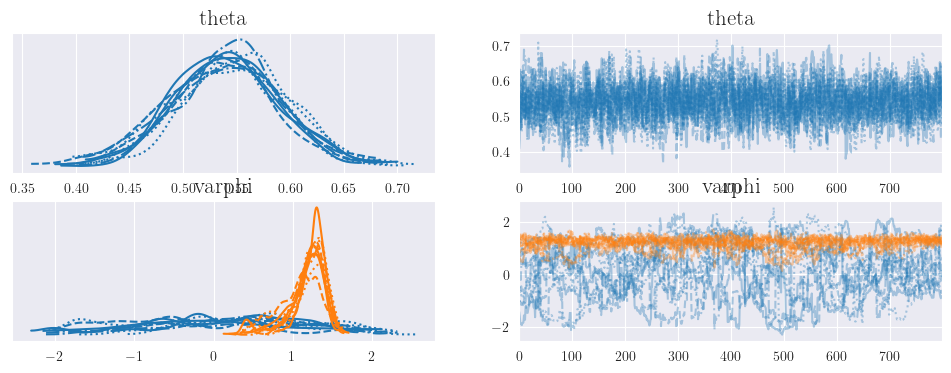

In [2]:
art = wandb.Api().artifact('ddold/semi_subspace_split_v2/data_rplnpsfn:v0')
az_post_split1 = az.from_netcdf(art.file())
az.plot_trace(az_post_split1)

In [3]:
ids = ['kui5i8x7', 'krt5q8gn', 'kah9vbm9', 'euvcu2p7', 'p29stwk2', 'n8oi2wuz']
split = [1,2,5,6,4,3] 
az_posteriors_melanoma = [az.from_netcdf(wandb.Api().artifact(f'ddold/semi_subspace_split_v2/data_{id}:v0').file()) for id in ids]

In [4]:
az.summary(az_posteriors_melanoma[0])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"theta[0, 0]",0.497,0.053,0.397,0.596,0.001,0.001,2135.0,2788.0,1.00
varphi[0],1.368,0.815,-0.104,2.921,0.062,0.044,168.0,271.0,1.06
varphi[1],0.702,0.382,-0.090,1.274,0.029,0.020,197.0,301.0,1.05


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

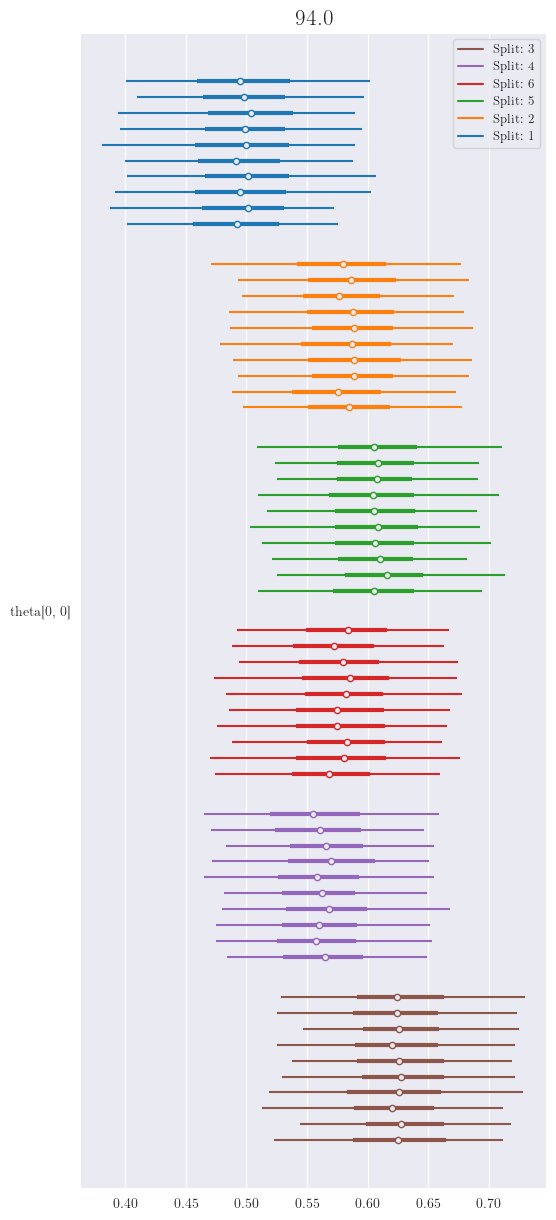

In [5]:
az.plot_forest(az_posteriors_melanoma, var_names='theta', model_names=[f"Split: {i}" for i in split])

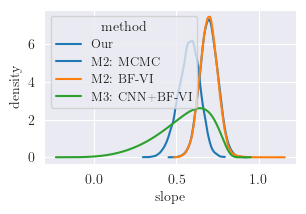

In [8]:
ax = az.plot_dist(az_post_all.posterior['theta'], label="Our")
df_bf = pd.read_csv("bf_vi.txt")
sns.lineplot(data=df_bf, x='slope', y='density', hue='method', ax=ax)
plt.show()

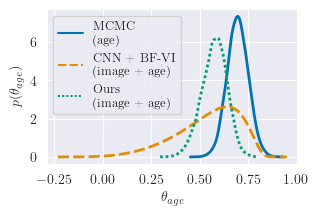

In [9]:
from scipy import stats
plt.figure(figsize=figsize)
theta_samples = az_post_all.posterior['theta'].to_numpy().flatten()
kernel = stats.gaussian_kde(theta_samples)
thetas = np.linspace(theta_samples.min(), theta_samples.max(), 1000)
density = kernel(thetas)
df_density_ours = pd.DataFrame({'method': 'Ours \n(image + age)', 'slope':thetas, 'density':density})
df_density = pd.concat([df_bf.drop(columns='Unnamed: 0'), df_density_ours])
df_density['method'].replace(['M2: MCMC'], 'MCMC \n(age)', inplace=True)
df_density['method'].replace(['M3: CNN+BF-VI'], 'CNN + BF-VI \n(image + age)', inplace=True)
sns.lineplot(data=df_density.reset_index(), x='slope', y='density', hue='method', palette='colorblind', style='method', linewidth=2,
             hue_order=['MCMC \n(age)',
                        'CNN + BF-VI \n(image + age)',
                        'Ours \n(image + age)'],
             style_order=['MCMC \n(age)',
                          'CNN + BF-VI \n(image + age)',
                          'Ours \n(image + age)'])
plt.xlabel(r"$\theta_{age}$")
plt.ylabel(r"$p(\theta_{age})$")
plt.legend(loc="upper left")

In [14]:
# ids_la = ['4n10owj1', 'bryh1zbl', 'yjc04t0m', '4946qova', 'f37px6qw', 's0pobmao']
# ids_la = ['cldxkjnn', 'u6qoqth1', 'on5lat9r', 'kj5ioyxu', 'swiihcf4', 'la3vzo3x'] # lr 0.0001 single seed
# ids_la = ['aqwfwtpj', 'zmky8evn', 'tztz9ngb', 'ak6rjrng', 'w60zdmd8', 'f9qz44p6'] # lr 0.01
ids_la = ['l3ljcruk', 'aeeo6pso', '6eqm3cfy', 'z63fipua', 'g4wk8x11', 'qa4xa7dh'] # lr 0.005
# ids_la = ['7ioh7vzo', 'h638mz0b', 'vop8q2kk', 'qyxto3fq', 'x5x2z1qj', '0w6jkl9g'] # lr 0.0001 random seed
split_la = [1,2,3,4,5,6] 
laplace_posterior = [az.from_netcdf(wandb.Api().artifact(f'ddold/semi_subspace_split_v2/data_{id}:v0').get_path("post_laplace_theta.nc").download()) for id in ids_la]

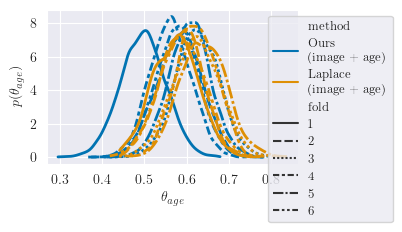

In [25]:
from scipy import stats
plt.figure(figsize=figsize)
# Load our posterior samples
theta_samples = az_post_all.posterior['theta'].to_numpy().flatten()
kernel = stats.gaussian_kde(theta_samples)
thetas = np.linspace(theta_samples.min(), theta_samples.max(), 1000)
density = kernel(thetas)
df_density_ours = pd.DataFrame({'method': 'Ours \n(image + age)', 'slope':thetas, 'density':density})

df_density_ours = []
for i, (s, post) in enumerate(zip(split, az_posteriors_melanoma)):
    # Load Laplace posterior samples
    theta_samples = post.posterior['theta'].to_numpy().flatten()
    kernel = stats.gaussian_kde(theta_samples)
    thetas = np.linspace(theta_samples.min(), theta_samples.max(), 1000)
    density = kernel(thetas)
    df_density_ours.append(pd.DataFrame({'method': f'Ours \n(image + age)', 'slope':thetas, 'density':density, 'fold':s}))

df_density_laplace = []
for i, (s, post) in enumerate(zip(split_la, laplace_posterior)):
    # Load Laplace posterior samples
    theta_samples = post.posterior['theta'].to_numpy().flatten()
    kernel = stats.gaussian_kde(theta_samples)
    thetas = np.linspace(theta_samples.min(), theta_samples.max(), 1000)
    density = kernel(thetas)
    df_density_laplace.append(pd.DataFrame({'method': f'Laplace \n(image + age)', 'slope':thetas, 'density':density, 'fold':s}))

df_density = pd.concat([*df_density_ours, *df_density_laplace])
sns.lineplot(data=df_density.reset_index(), x='slope', y='density', hue='method', palette='colorblind', style='fold', linewidth=2)
plt.xlabel(r"$\theta_{age}$")
plt.ylabel(r"$p(\theta_{age})$")
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 1.), ncols=1)

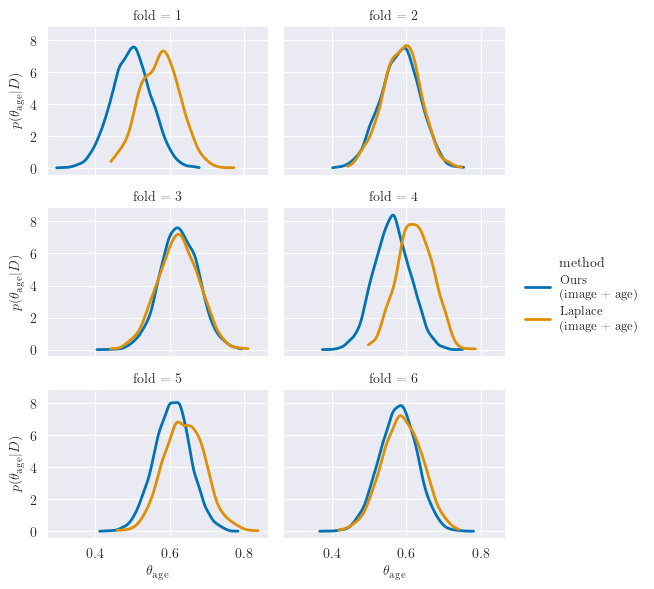

In [26]:
# Create a FacetGrid
g = sns.FacetGrid(data=df_density, col='fold', hue='method', palette='colorblind', col_wrap=2, height=2, sharex=True)
# Plot KDEs in each subplot
g.map(sns.lineplot, 'slope', 'density', linewidth=2)

# Set labels and legend
g.set_axis_labels(x_var=r"$\theta_{\text{age}}$", y_var=r"$p(\theta_{\text{age}}|D)$")
g.add_legend(loc='center right', bbox_to_anchor=(1.25, .5))
plt.tight_layout()
plt.savefig("figures2/melanoma_posterior_laplace_our_fold_compare.pdf", bbox_inches='tight')

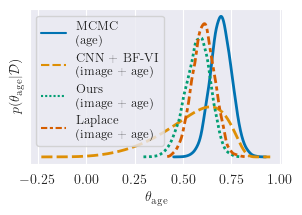

In [36]:
from scipy import stats
plt.figure(figsize=figsize)
# Load our posterior samples
theta_samples = az_post_all.posterior['theta'].to_numpy().flatten()
kernel = stats.gaussian_kde(theta_samples)
thetas = np.linspace(theta_samples.min(), theta_samples.max(), 1000)
density = kernel(thetas)
df_density_ours = pd.DataFrame({'method': 'Ours \n(image + age)', 'slope':thetas, 'density':density})
# Load Laplace posterior samples
theta_samples = az.concat(laplace_posterior, dim='chain').posterior['theta'].to_numpy().flatten()
kernel = stats.gaussian_kde(theta_samples)
thetas = np.linspace(theta_samples.min(), theta_samples.max(), 1000)
density = kernel(thetas)
df_density_laplace = pd.DataFrame({'method': 'Laplace \n(image + age)', 'slope':thetas, 'density':density})

df_density = pd.concat([df_bf.drop(columns='Unnamed: 0'), df_density_ours, df_density_laplace])
df_density['method'].replace(['M2: MCMC'], 'MCMC \n(age)', inplace=True)
df_density['method'].replace(['M3: CNN+BF-VI'], 'CNN + BF-VI \n(image + age)', inplace=True)
sns.lineplot(data=df_density.reset_index(), x='slope', y='density', hue='method', palette='colorblind', style='method', linewidth=2,
             hue_order=['MCMC \n(age)',
                        'CNN + BF-VI \n(image + age)',
                        'Ours \n(image + age)',
                        'Laplace \n(image + age)'],
             style_order=['MCMC \n(age)',
                          'CNN + BF-VI \n(image + age)',
                          'Ours \n(image + age)',
                          'Laplace \n(image + age)'])
plt.xlabel(r"$\theta_{\text{age}}$")
plt.ylabel(r"$p(\theta_{\text{age}}|\mathcal{D})$")
plt.legend(loc="upper left")
plt.yticks([])
plt.savefig("figures2/melanoma_posterior.pdf", bbox_inches='tight')

## Analyse optimization asymetrie

In [27]:
ids_la_failed = ['7ioh7vzo', 'h638mz0b', 'vop8q2kk', 'qyxto3fq', 'x5x2z1qj', '0w6jkl9g'] # lr 0.0001 random seed
split_la = [1,2,3,4,5,6] 
laplace_posterior_failed = [az.from_netcdf(wandb.Api().artifact(f'ddold/semi_subspace_split_v2/data_{id}:v0').get_path("post_laplace_theta.nc").download()) for id in ids_la_failed]

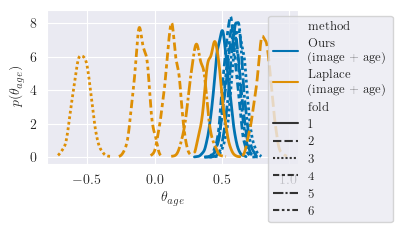

In [30]:
from scipy import stats
plt.figure(figsize=figsize)
df_density_laplace_failed = []
for i, (s, post) in enumerate(zip(split_la, laplace_posterior_failed)):
    # Load Laplace posterior samples
    theta_samples = post.posterior['theta'].to_numpy().flatten()
    kernel = stats.gaussian_kde(theta_samples)
    thetas = np.linspace(theta_samples.min(), theta_samples.max(), 1000)
    density = kernel(thetas)
    df_density_laplace_failed.append(pd.DataFrame({'method': f'Laplace \n(image + age)', 'slope':thetas, 'density':density, 'fold':s}))

df_density_failed = pd.concat([*df_density_ours, *df_density_laplace_failed])
sns.lineplot(data=df_density_failed.reset_index(), x='slope', y='density', hue='method', palette='colorblind', style='fold', linewidth=2)
plt.xlabel(r"$\theta_{age}$")
plt.ylabel(r"$p(\theta_{age})$")
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 1.), ncols=1)

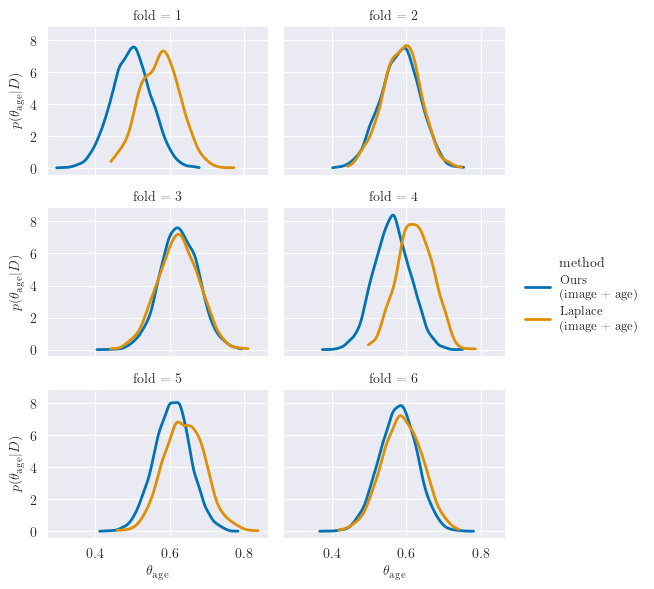

In [29]:
# Create a FacetGrid
g = sns.FacetGrid(data=df_density, col='fold', hue='method', palette='colorblind', col_wrap=2, height=2, sharex=True)
# Plot KDEs in each subplot
g.map(sns.lineplot, 'slope', 'density', linewidth=2)

# Set labels and legend
g.set_axis_labels(x_var=r"$\theta_{\text{age}}$", y_var=r"$p(\theta_{\text{age}}|D)$")
g.add_legend(loc='center right', bbox_to_anchor=(1.25, .5))
plt.tight_layout()
# plt.savefig("figures2/melanoma_posterior_laplace_our_fold_compare.pdf", bbox_inches='tight')

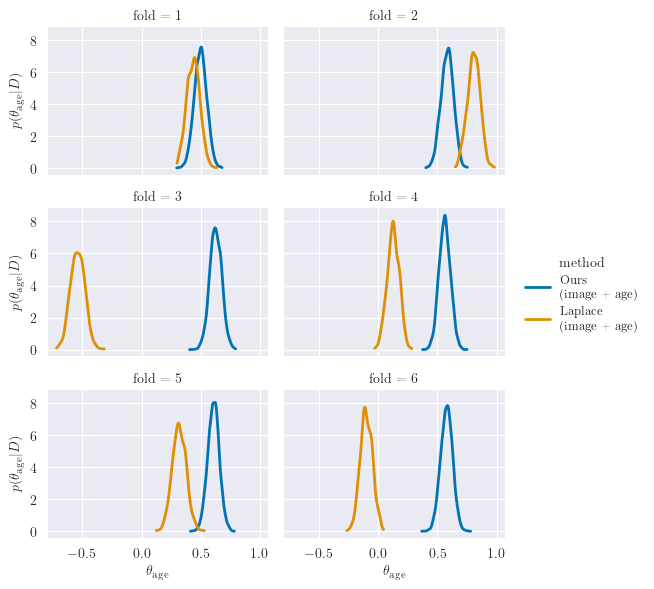

In [31]:
# # -> with small leraning rate <-
# Create a FacetGrid
g = sns.FacetGrid(data=df_density_failed, col='fold', hue='method', palette='colorblind', col_wrap=2, height=2, sharex=True)
# Plot KDEs in each subplot
g.map(sns.lineplot, 'slope', 'density', linewidth=2)

# Set labels and legend
g.set_axis_labels(x_var=r"$\theta_{\text{age}}$", y_var=r"$p(\theta_{\text{age}}|D)$")
g.add_legend(loc='center right', bbox_to_anchor=(1.25, .5))
plt.tight_layout()
plt.savefig("figures2/melanoma_posterior_laplace_our_fold_compare_0lr0001.pdf", bbox_inches='tight')

In [73]:
run = wandb.Api().run('ddold/semi_subspace_split_v2/vop8q2kk')
logged_data = run.history().apply(pd.to_numeric, errors='coerce')
logged_data.dropna(subset=['valid/loss'], inplace=True)
logged_data

,_step,epoch,_runtime,_timestamp,valid/loss,trainer/global_step,valid/MulticlassAUROC,valid/MulticlassF1Score,valid/MulticlassAccuracy,valid/MulticlassAveragePrecision,valid/MulticlassCalibrationError,train/loss_epoch,train/loss_step,test/loss,test/MulticlassAUROC,test/MulticlassF1Score,test/MulticlassAccuracy,test/MulticlassAveragePrecision,test/MulticlassCalibrationError
0,1,0,58.895002,1.697479e+09,0.096955,77,0.345330,0.983666,0.983666,0.492587,0.002517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,12,3,67.291349,1.697479e+09,0.095922,311,0.358000,0.983666,0.983666,0.494385,0.001220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,19,5,72.980011,1.697479e+09,0.092450,467,0.438939,0.983666,0.983666,0.500404,0.001218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,26,7,78.634241,1.697479e+09,0.089662,623,0.524501,0.983666,0.983666,0.507349,0.002668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,30,8,81.471081,1.697479e+09,0.089004,701,0.561514,0.983666,0.983666,0.508853,0.003087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,439,123,405.650736,1.697479e+09,0.200673,9671,0.721363,0.978826,0.978826,0.526163,0.018541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
317,446,125,411.277938,1.697479e+09,0.202030,9827,0.717105,0.979583,0.979583,0.526906,0.018411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
320,450,126,414.098404,1.697479e+09,0.203858,9905,0.712703,0.979734,0.979734,0.525380,0.018486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
331,464,130,425.361312,1.697479e+09,0.204994,10217,0.713755,0.978978,0.978978,0.526543,0.018555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


{'lr': 0.0001,
 'seed': 13,
 'split': 3,
 'ds_name': 'melanom',
 'loss_fn': None,
 'data_dir': 'dataset/siim_isic',
 'batch_size': 256,
 'output_dim': 1,
 'weight_decay': 0.0001,
 'meta_features': ['age_approx'],
 'num_structure': 1,
 'classification': False,
 'reuse_artifact': True,
 'seed_for_split': 0,
 'index_file_name': 'melanoma_ridx.csv',
 'metric_collection': None,
 'ortho_layer_name_nn_head': None}

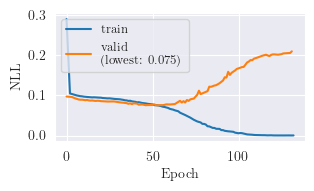

In [97]:
run = wandb.Api().run('ddold/semi_subspace_split_v2/vop8q2kk')
logged_data = run.history().apply(pd.to_numeric, errors='coerce')
# logged_data.dropna(subset=['valid/loss'], inplace=True)

# Create a custom plot
sns.lineplot(data=logged_data, x='epoch', y='train/loss_epoch', label='train')
sns.lineplot(data=logged_data, x='epoch', y='valid/loss', label=f"valid \n(lowest: {logged_data['valid/loss'].min():.3f})")
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.legend()
plt.tight_layout()
plt.savefig("figures2/melanoma_posterior_laplace_failed_train_val_loss.pdf", bbox_inches='tight')
run.config

{'lr': 0.005,
 'seed': 13,
 'split': 3,
 'ds_name': 'melanom',
 'loss_fn': None,
 'data_dir': 'dataset/siim_isic',
 'batch_size': 256,
 'output_dim': 1,
 'weight_decay': 0.0001,
 'meta_features': ['age_approx'],
 'num_structure': 1,
 'classification': False,
 'reuse_artifact': True,
 'seed_for_split': 0,
 'index_file_name': 'melanoma_ridx.csv',
 'metric_collection': None,
 'ortho_layer_name_nn_head': None}

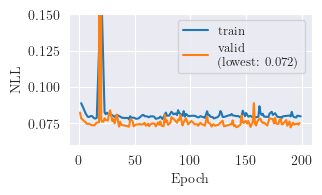

In [96]:
run = wandb.Api().run('ddold/semi_subspace_split_v2/6eqm3cfy')
logged_data = run.history().apply(pd.to_numeric, errors='coerce')
# logged_data.dropna(subset=['valid/loss'], inplace=True)

# Create a custom plot
sns.lineplot(data=logged_data, x='epoch', y='train/loss_epoch', label='train')
sns.lineplot(data=logged_data, x='epoch', y='valid/loss', label=f"valid \n(lowest: {logged_data['valid/loss'].min():.3f})")
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.ylim(0.06, 0.15)
plt.legend()
plt.tight_layout()
plt.savefig("figures2/melanoma_posterior_laplace_train_val_loss.pdf", bbox_inches='tight')
run.config

In [ ]:
run = wandb.Api().run('ddold/semi_subspace_split_v2/vop8q2kk')
logged_data = run.history().apply(pd.to_numeric, errors='coerce')
# logged_data.dropna(subset=['valid/loss'], inplace=True)

# Create a custom plot
sns.lineplot(data=logged_data, x='epoch', y='train/loss_epoch', label='train')
sns.lineplot(data=logged_data, x='epoch', y='valid/loss', label=f"valid \n(lowest: {logged_data['valid/loss'].min():.3f})")
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.legend()
plt.tight_layout()
plt.savefig("figures2/melanoma_posterior_laplace_failed_train_val_loss.pdf", bbox_inches='tight')

## Analyse predictive performance

In [25]:
data_col = []
for fold, id in zip(split, ids):
    run = wandb.Api().run(path=f"ddold/semi_subspace_split_v2/{id}")
    lppd = run.summary['test_lppd']
    data_col.append({'method': 'Ours', 
            'lppd': run.summary['test_lppd'],
            'AUROC': run.summary['test/MulticlassAUROC'],
            'fold': fold})
for fold, id in zip(split_la, ids_la):
    run = wandb.Api().run(path=f"ddold/semi_subspace_split_v2/{id}")
    lppd = run.summary['test_lppd']
    data_col.append({'method': 'Laplace', 
            'lppd': run.summary['test_lppd'],
            'AUROC': run.summary['test/MulticlassAUROC'],
            'fold': fold})
summary = pd.DataFrame(data_col)
summary.rename(columns={'AUROC':'auc'}, inplace=True)
summary['nll'] = summary['lppd'] / -6612
summary['lppd'] /= 6612
# summary = summary.melt(id_vars=('method', 'fold'), var_name='metric', value_name='val')
summary

,method,lppd,auc,fold,nll
0,Ours,-0.071942,0.849339,1,0.071942
1,Ours,-0.070373,0.839556,2,0.070373
2,Ours,-0.074260,0.828535,5,0.074260
3,Ours,-0.069470,0.847279,6,0.069470
4,Ours,-0.071571,0.835725,4,0.071571
5,Ours,-0.076251,0.843657,3,0.076251
6,Laplace,-0.075360,0.799461,1,0.075360
7,Laplace,-0.074941,0.795122,2,0.074941
8,Laplace,-0.080604,0.801577,3,0.080604
9,Laplace,-0.076015,0.788578,4,0.076015


In [26]:
data_kook = pd.read_csv("met_negloglik_data.csv")
data_kook = data_kook[(data_kook['mod'] == 'cils') & (data_kook['method'] == 'trafo') & (data_kook['weights'] == 'tuned')]
data_kook = data_kook.drop(columns=['mod', 'weights']).rename(columns={'spl':'fold'})
data_kook = data_kook.pivot_table(index=['method','fold'], columns='metric', values='val')
data_kook

metric            acc       auc    binacc    binnll     brier      cint   
method fold                                                               
trafo  1     0.983061  0.825084  0.983061  0.072141  0.015821 -0.163707  \
       2     0.983212  0.801049  0.983212  0.072716  0.015565 -0.097415   
       3     0.981397  0.803857  0.981397  0.079099  0.017312  0.027989   
       4     0.983364  0.776902  0.983364  0.074738  0.015724  0.046211   
       5     0.982910  0.821096  0.982910  0.074191  0.016169  0.214824   
       6     0.983364  0.792847  0.983364  0.073135  0.015606 -0.087185   

metric         cslope      eacc      eauc   ebinacc      eqwk       nll   
method fold                                                               
trafo  1     1.114732  0.016939  0.174916  0.016939  1.000000  0.072141  \
       2     1.172251  0.016788  0.198951  0.016788  1.000000  0.072716   
       3     1.114052  0.018603  0.196143  0.018603  0.984872  0.079099   
       4     1.053358  0.016636  0.223098  0.016636  1.000000  0.074738   
       5     1.211269  0.017090  0.178904  0.017090  1.000000  0.074191   
       6     1.389875  0.016636  0.207153  0.016636  1.000000  0.073135   

metric            qwk       rps  
method fold                      
trafo  1     0.000000  0.015821  
       2     0.000000  0.015565  
       3     0.015128  0.017312  
       4     0.000000  0.015724  
       5     0.000000  0.016169  
       6     0.000000  0.015606

In [27]:
sum_all = pd.concat([summary, data_kook.reset_index()], ignore_index=True, axis=0)
# sum_all = sum_all.pivot_table(index=['method','fold'], columns='metric', values='val')
# sum_all.reset_index(inplace=True)
sum_all

,method,lppd,auc,fold,nll,acc,binacc,binnll,brier,cint,cslope,eacc,eauc,ebinacc,eqwk,qwk,rps
0,Ours,-0.071942,0.849339,1,0.071942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ours,-0.070373,0.839556,2,0.070373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ours,-0.074260,0.828535,5,0.074260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Ours,-0.069470,0.847279,6,0.069470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ours,-0.071571,0.835725,4,0.071571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Ours,-0.076251,0.843657,3,0.076251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Laplace,-0.075360,0.799461,1,0.075360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Laplace,-0.074941,0.795122,2,0.074941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Laplace,-0.080604,0.801577,3,0.080604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Laplace,-0.076015,0.788578,4,0.076015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='method', ylabel='lppd'>

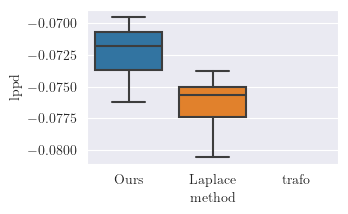

In [28]:
sns.boxplot(data=sum_all, x='method', y='lppd', hue_order=['Ours', 'Laplace', 'Trafo'])

<Axes: xlabel='method', ylabel='auc'>

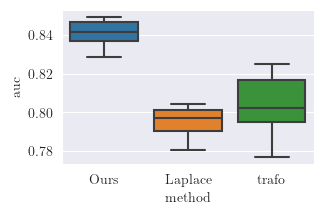

In [29]:
sns.boxplot(data=sum_all, x='method', y='auc')

In [133]:
sum_all.loc[:, ['method', 'auc','lppd', 'nll']]

,method,auc,lppd,nll
0,trafo,0.825084,NaN,0.072141
1,trafo,0.801049,NaN,0.072716
2,trafo,0.803857,NaN,0.079099
3,trafo,0.776902,NaN,0.074738
4,trafo,0.821096,NaN,0.074191
5,trafo,0.792847,NaN,0.073135
6,Ours,0.849339,-0.071942,NaN
7,Ours,0.839556,-0.070373,NaN
8,Ours,0.828535,-0.074260,NaN
9,Ours,0.847279,-0.069470,NaN


In [31]:
sum_all.loc[:, ['method', 'auc', 'nll', 'lppd']].groupby('method').describe()

auc                                                               
        count      mean       std       min       25%       50%       75%   
method                                                                      
Laplace   6.0  0.794922  0.009007  0.780404  0.790214  0.797291  0.801048  \
Ours      6.0  0.840682  0.007755  0.828535  0.836683  0.841607  0.846374   
trafo     6.0  0.803473  0.017903  0.776902  0.794898  0.802453  0.816786   

                    nll            ...                      lppd             
              max count      mean  ...       75%       max count      mean   
method                             ...                                       
Laplace  0.804391   6.0  0.076430  ...  0.077396  0.080604   6.0 -0.076430  \
Ours     0.849339   6.0  0.072311  ...  0.073681  0.076251   6.0 -0.072311   
trafo    0.825084   6.0  0.074337  ...  0.074601  0.079099   0.0       NaN   

                                                                     
              std       min       25%       50%       75%       max  
method                                                               
Laplace  0.002445 -0.080604 -0.077396 -0.075688 -0.075046 -0.073805  
Ours     0.002523 -0.076251 -0.073681 -0.071757 -0.070672 -0.069470  
trafo         NaN       NaN       NaN       NaN       NaN       NaN  

[3 rows x 24 columns]

In [32]:
mean = sum_all.loc[:, ['method', 'auc', 'lppd']].groupby('method').mean()
std_err = sum_all.loc[:, ['method', 'auc', 'lppd']].groupby('method').agg(lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
summ_des = pd.concat([mean, std_err], axis=1, keys=['Mean', 'Stderr']).swaplevel(axis=1).sort_index(axis=1)
print(summ_des.to_latex(float_format="{:.3f}".format))

\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{2}{r}{auc} & \multicolumn{2}{r}{lppd} \\
 & Mean & Stderr & Mean & Stderr \\
method &  &  &  &  \\
\midrule
Laplace & 0.795 & 0.004 & -0.076 & 0.001 \\
Ours & 0.841 & 0.003 & -0.072 & 0.001 \\
trafo & 0.803 & 0.007 & NaN & NaN \\
\bottomrule
\end{tabular}



In [156]:
summ_des = sum_all.loc[:, ['method', 'auc', 'nll']].groupby('method').describe()
summ_des = summ_des.loc[:,(('auc', 'nll'), ('mean','std'))]
print(summ_des.to_latex(float_format="{:.3f}".format))

\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{2}{r}{auc} & \multicolumn{2}{r}{nll} \\
 & mean & std & mean & std \\
method &  &  &  &  \\
\midrule
Laplace & 0.795 & 0.009 & 0.076 & 0.002 \\
Ours & 0.841 & 0.008 & 0.072 & 0.003 \\
trafo & 0.803 & 0.018 & 0.074 & 0.003 \\
\bottomrule
\end{tabular}



In [62]:
from torchinfo import summary
from tabulate import tabulate
outcome_dist = pyro.distributions.Bernoulli  # outcome distributions
loss_fn = NllLoss(outcome_dist,
                  constrains={'probs': torch.nn.Sigmoid()},
                  reduction=None)
# args
net_kwargs = dict(lr=1e-4,
                  weight_decay=1e-4,
                  loss_fn=loss_fn,
                  num_structure=1,
                  output_dim=1
                  )
model = getModel(SimpleCnn, **net_kwargs)
del(model.valid_metrics)
del(model.test_metrics)
summary_text = summary(model) # input_data=(torch.randn(256,3,128,128), torch.randn(256,1)), batch_dim=0)
latex_code = tabulate(summary_text.__repr__(), headers="keys", tablefmt="latex_raw")
latex_code

SemiAdditive


'\\begin{tabular}{l}\n\\hline\n 0   \\\\\n\\hline\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n =   \\\\\n     \\\\\n L   \\\\\n a   \\\\\n y   \\\\\n e   \\\\\n r   \\\\\n     \\\\\n (   \\\\\n t   \\\\\n y   \\\\\n p   \\\\\n e   \\\\\n :   \\\\\n d   \\\\\n e   \\\\\n p   \\\\\n t   \\\\\n h   \\\\\n -   \\\\\n i   \\\\\n d   \\\\\n x 

In [64]:
model

SemiAdditiveModel(
  (loss_fn): NllLoss(OutcomeDistributionLayer(dist=<class 'pyro.distributions.torch.Bernoulli'>; constrains={'probs': Sigmoid()})) with reduction=None
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): Tanh()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): Tanh()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): Tanh()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l

In [63]:
summary_text

Layer (type:depth-idx)                   Param #
SemiAdditiveModel                        --
├─NllLoss: 1-1                           --
│    └─OutcomeDistributionLayer: 2-1     --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-2                       896
│    └─Tanh: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─Conv2d: 2-5                       9,248
│    └─Tanh: 2-6                         --
│    └─MaxPool2d: 2-7                    --
│    └─Conv2d: 2-8                       18,496
│    └─Tanh: 2-9                         --
│    └─MaxPool2d: 2-10                   --
│    └─Conv2d: 2-11                      36,928
│    └─Tanh: 2-12                        --
│    └─MaxPool2d: 2-13                   --
│    └─Conv2d: 2-14                      73,856
│    └─Tanh: 2-15                        --
│    └─MaxPool2d: 2-16                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-17                     --
│    └─Line

## recompute metrics

In [43]:
wandb_logger = WandbLogger(project='semi_subspace_split_v2', log_model=False, name='Only_load', group="SimpleCnnCurve", resume='never')       
transform = nn.Sequential(torchvision.transforms.ConvertImageDtype(torch.float32),
                            torchvision.transforms.Normalize((0.8061, 0.6210, 0.5914), (0.1484, 0.1748, 0.1999)))
transform = torch.jit.trace(transform, torch.randint(0, 255, (3, 128, 128), dtype=torch.uint8))
dm = MelanomDataModuleFromSplit(wandb_logger=wandb_logger,
                                # **vars(args),
                                data_dir="dataset/siim_isic",
                                batch_size=256,
                                reuse_artifact=True,
                                meta_features=['age_approx'],
                                split=1,
                                transform_test=transform,
                                transform_train=transform)
dm.prepare_data()
dm.setup()
u, x, y = [], [], []
for (uu, xx), yy in dm.test_dataloader():
    u.append(uu)
    x.append(xx)
    y.append(yy)
y = torch.hstack(y)
print(len(y))
wandb.finish()

wandb: Currently logged in as: ddold. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact melanom_dataset:latest, 89.10MB. 35134 files... 
wandb:   35134 of 35134 files downloaded.  
Done. 0:0:2.9
wandb:   4 of 4 files downloaded.  


move data to from dataset/siim_isic/melanom_ds to RAM /dev/shm/melanom_ds...
data_dir:  dataset/siim_isic
DM setup done
6612


In [35]:
outcome_dist = pyro.distributions.Bernoulli  # outcome distributions
loss_fn = NllLoss(outcome_dist,
                  constrains={'probs': torch.nn.Sigmoid()},
                  reduction=None)
# args
net_kwargs = dict(lr=1e-4,
                  weight_decay=1e-4,
                  loss_fn=loss_fn,
                  num_structure=1,
                  output_dim=1
                  )
seed=0
# load data
transform = nn.Sequential(torchvision.transforms.ConvertImageDtype(torch.float32),
                            torchvision.transforms.Normalize((0.8061, 0.6210, 0.5914), (0.1484, 0.1748, 0.1999)))
transform = torch.jit.trace(transform, torch.randint(0, 255, (3, 128, 128), dtype=torch.uint8))
wandb_logger = WandbLogger(project='semi_subspace_split_v2', log_model=False, name='Only_load',
                            group="SimpleCnnCurve", resume='never')

for r in wandb.Api().runs("ddold/semi_subspace_split_v2"):
    if r.group == "SemiSub":
        print(r.name)
        for art in r.logged_artifacts():
            # Load samples
            if "data" in art.name:
                samples_reload = az.from_netcdf(art.file())
                samples = np.concatenate([samples_reload.posterior['varphi'].to_numpy().reshape(-1,2).T, samples_reload.posterior['theta'].to_numpy().reshape(-1,1).T])
            # load subspace model
            if "model_state" in art.name:
                state_dict = torch.load(art.file(), map_location=device)
                subspace_model = getModel(SimpleCnn, seed=seed, **net_kwargs, mean=state_dict['mean'], cov_factor=state_dict['cov_factor']).to(device=device)
                subspace_model.load_state_dict(state_dict)
        
        # prepare test data
        for art_in in r.used_artifacts():
            if "model_state" in art_in.name:
                split = art_in.logged_by().config['split']
        dm = MelanomDataModuleFromSplit(wandb_logger=wandb_logger,
                                # **vars(args),
                                data_dir="dataset/siim_isic",
                                batch_size=256,
                                reuse_artifact=True,
                                meta_features=['age_approx'],
                                split=split,
                                transform_test=transform,
                                transform_train=transform)
        dm.prepare_data()
        dm.setup()
        u, x, y = [], [], []
        for (uu, xx), yy in dm.test_dataloader():
            u.append(uu)
            x.append(xx)
            y.append(yy)
        u = torch.vstack(u).to(device=device)
        x = torch.vstack(x).to(device=device)
        y = torch.hstack(y).to(device=device)
        dataset = torch.utils.data.TensorDataset(u,x,y)
        test_loader = FastFillTensorDataLoader(dataset, batch_size=len(dataset)//5, shuffle=False, pin_memory=False)
        
        # Create ESS modle
        ess = SemiSubEllipticalSliceSampling(subspace_model,
                                        prior_scale=1.,
                                        prior_scale_subspace=5.,
                                        temperature=1.,
                                        temperature_only_on_nn=False,
                                        num_integration_samples=2000,
                                        num_chains=1,
                                        num_warmup=2,
                                        integration_range=20.,
                                        device=device,
                                        criterion=loss_fn,
                                        num_samples=3,
                                        seed=seed+3)
        # run predictions with samples
        preds = []
        obs = []
        for data, y_valid in test_loader:
            pred = ess.predict(samples.T, data)
            preds.append(pred)
            obs.append(y_valid)
        preds = torch.concatenate(preds, dim=1) # shape: (#samples,#data,#params)
        obs = torch.concatenate(obs, dim=-1)
        lppd = (torch.logsumexp(-loss_fn(preds, obs), dim=0) - np.log(preds.shape[0])).sum()
        assert np.isclose(lppd.item(), r.summary['test_lppd']), f"Lppd differs from wandb. Wandb {r.summary['test_lppd']}, recompute {lppd}"
        print('lppd: ', lppd)
        post_pred_prob = loss_fn.dist_(preds).mean.mean(0)
        auroc = torchmetrics.functional.auroc(post_pred_prob, obs.to(dtype=torch.long), task='binary').item()
        r.summary['test/MulticlassAUROC'] = auroc

        acc = torchmetrics.functional.accuracy(post_pred_prob, obs.to(dtype=torch.long), task='binary').item()
        r.summary['test/MulticlassAccuracy'] = acc

        avgp = torchmetrics.functional.average_precision(post_pred_prob, obs.to(dtype=torch.long), task='binary').item()
        r.summary['test/MulticlassAveragePrecision'] = avgp

        calb_error = torchmetrics.functional.calibration_error(post_pred_prob, obs.to(dtype=torch.long), task='binary').item()
        r.summary['test/MulticlassCalibrationError'] = calb_error

        f1_score = torchmetrics.functional.f1_score(post_pred_prob, obs.to(dtype=torch.long), task='binary').item()
        r.summary['test/MulticlassF1Score'] = f1_score

        r.summary.update()        

wandb.finish()

wandb: Downloading large artifact melanom_dataset:latest, 89.10MB. 35134 files... 
wandb:   35134 of 35134 files downloaded.  
Done. 0:0:3.1
wandb:   4 of 4 files downloaded.  


move data to from dataset/siim_isic/melanom_ds to RAM /dev/shm/melanom_ds...
data_dir:  dataset/siim_isic
DM setup done
